# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.33
acceptance rate:  0.3316363636363636


/home/ubuntu/pyknos/pyknos/mdn/mdn.py:288: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  chosen_precision_factors,


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.308
acceptance rate:  0.33036363636363636
tensor([4.8296, 5.3559, 6.0301, 3.8037, 3.8501, 9.1264, 8.2499, 5.2507, 3.6969,
        8.7818, 2.0861, 4.1848, 2.1141, 8.0785, 4.2285])
tensor([11.2057, 24.8240, 29.4990,  8.7109, 71.8655, 51.8188, 36.9014, 43.7151,
         7.5725, 75.3172,  3.8781, 48.3548, 96.7298, 27.2452, 36.4100])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 43.2545, 189.3360,  61.0003,   6.2291, 169.9934,  43.9945,  80.4395,
         151.3238,  11.4073,  50.0238,   1.5700, 162.5020,   3.5631, 111.3843,
          43.8920]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.288
acceptance rate:  0.27036363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.267
acceptance rate:  0.2635454545454545
tensor([ 5.0357,  4.7165,  6.5902, 12.0508,  5.7956,  6.7736,  4.1729,  5.7612,
         4.8161,  7.3372,  6.0564,  5.7405,  3.7453,  4.5485,  6.6259])
tensor([12.3270, 11.5453, 46.6831, 31.7931, 91.3438, 58.6180, 10.6888, 35.9840,
        15.3382, 61.0092, 20.0177, 78.5768, 95.6655, 42.0836, 47.6702])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 54.0594,  24.4465, 375.3244, 307.0914,  15.4401,  27.0729, 139.8058,
          54.7011,  73.8029,  64.8416, 128.8051,  93.3164,  10.7526,  10.5003,
          23.1250]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.941
acceptance rate:  0.9326363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.944
acceptance rate:  0.932
tensor([9.0687, 5.7619, 4.2316, 4.7683, 7.6975, 3.2334, 8.6560, 4.4220, 9.7543,
        6.2528, 3.8263, 2.9632, 3.0992, 6.2966, 8.3388])
tensor([30.6501, 28.9403, 36.4585, 24.6859, 60.1484, 59.2969, 50.6435, 33.1450,
        43.2887, 54.5867, 21.1517, 50.7301, 91.1221, 22.3393, 80.5371])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[420.6808, 277.4773, 142.4515, 117.1436, 472.6438,  12.7855, 314.3124,
          26.6707, 816.5947, 136.0000, 135.9169, 119.3897,  34.2021, 173.4327,
         663.5911]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.237
acceptance rate:  0.26


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.275
acceptance rate:  0.27036363636363636
tensor([1.7012, 1.6517, 4.1732, 1.2488, 3.0856, 2.2818, 1.5304, 2.2805, 2.1186,
        0.9211, 1.6364, 1.4000, 3.1593, 2.8233, 4.1702])
tensor([ 4.6219,  3.4521, 22.1330,  8.9173, 92.2437, 53.5832, 26.8572, 27.0392,
         4.7991, 68.5782,  3.6926, 64.8537, 95.3929, 40.4051, 42.4584])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.7311, 3.6082, 9.0539, 0.6436, 5.6507, 2.2819, 0.2557, 1.2766, 1.3128,
         1.0172, 1.2010, 0.8006, 9.8461, 2.5296, 9.9972]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.864
acceptance rate:  0.8728181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.871
acceptance rate:  0.8743636363636363
tensor([5.1934, 8.1850, 7.7913, 5.8951, 4.8368, 1.7532, 1.7069, 3.1665, 4.0823,
        3.5194, 2.8584, 2.9748, 4.6062, 4.8123, 6.7224])
tensor([16.6137, 34.1201, 18.1559, 21.5617, 88.7133, 51.5499, 28.1625, 17.6861,
         8.9965, 65.4008, 15.9923, 71.9090, 89.6781, 38.6193, 36.1381])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[104.0054, 426.2635,  29.4994,  81.9378,  10.4488,   6.4269,   1.0978,
          46.7346,  18.9087,  15.0112,  62.9507,  20.2925,  52.0300,  10.4611,
          59.4562]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.27
acceptance rate:  0.2770909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.29
acceptance rate:  0.2828181818181818
tensor([2.4988, 4.2520, 7.7982, 2.1033, 3.0363, 1.6882, 2.0635, 3.7270, 1.3866,
        2.2815, 1.3809, 3.0747, 3.1449, 2.1292, 8.8179])
tensor([ 8.8709, 13.7969, 35.4433, 14.3152, 88.0644, 52.3600, 29.8387, 33.5681,
         2.8109, 64.4296,  7.0181, 58.5533, 93.7711, 35.2372, 28.1406])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 18.9396,  37.4883, 147.1004,  10.2792,   4.8722,   3.8861,   4.9337,
          26.7000,   0.8415,  16.7926,   2.1671,  30.8306,  16.9701,  12.3530,
         178.3197]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.525
acceptance rate:  0.5429090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.547
acceptance rate:  0.5403636363636364
tensor([5.0077, 6.0185, 5.7569, 4.8897, 7.5242, 6.2834, 4.1770, 4.4250, 5.2547,
        6.0617, 3.9349, 6.3490, 5.1840, 3.3971, 8.5706])
tensor([ 9.3653, 16.6396, 11.3735, 14.6528, 64.8268, 44.3253, 24.8928, 25.7857,
         9.1035, 85.9547,  7.9440, 81.5912, 82.2970, 36.5489, 34.2910])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 30.6859,  72.4173,  51.5287,  20.6920, 342.6346,  74.3773,   9.0144,
           8.5403,  24.6697, 143.3457,  10.2052, 139.3492, 150.7867,  10.0025,
          91.4202]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.81
acceptance rate:  0.7970909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.801
acceptance rate:  0.7965454545454546
tensor([4.2720, 5.4685, 4.3686, 5.0250, 5.2698, 6.9399, 5.1952, 5.6074, 4.4452,
        4.2831, 5.8505, 7.0502, 6.8383, 5.8902, 6.9178])
tensor([17.2928, 13.1203, 12.9304, 21.6263, 90.8490, 31.7764, 12.4134, 42.5486,
        16.3876, 67.1382, 12.1352, 44.0669, 75.9504, 35.1247, 18.7423])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[109.3147,  38.1026,  32.5577,  78.0961,  12.0837, 291.3112, 117.7317,
         134.3763,  84.6140,  11.3125,  40.3032, 262.9312, 286.6010,  26.9581,
         366.2277]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.708
acceptance rate:  0.7046363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.685
acceptance rate:  0.7002727272727273
tensor([7.7993, 8.3423, 3.7755, 3.8678, 5.5996, 5.1370, 2.3122, 5.8176, 9.1852,
        4.1026, 6.9127, 5.4007, 3.0226, 5.9391, 7.5128])
tensor([15.3462, 20.5959, 17.6856,  9.3353, 83.7823, 61.3219, 15.4760, 41.0938,
        26.9689, 66.8282, 24.2163, 89.5781, 94.6119, 47.2601, 66.1808])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[104.0753, 138.6956,   7.9768,   5.8481,  32.7854,  31.0408,  67.7359,
         113.9797, 303.2523,  11.5341, 206.0921, 290.3605,  12.5897,  41.7096,
         250.0176]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.359
acceptance rate:  0.34345454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.347
acceptance rate:  0.3389090909090909
tensor([5.3289, 3.3044, 4.3128, 4.1319, 2.8441, 3.0943, 4.8214, 2.1060, 3.9868,
        5.1892, 2.1506, 2.9349, 3.4217, 8.4682, 4.6119])
tensor([ 8.9324,  5.8855,  7.0558, 16.1136, 92.5548, 54.3945, 32.5514, 28.1545,
        10.2998, 53.7896,  8.0556, 57.7475, 90.5649, 23.4346, 42.8013])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 29.6220,   3.7710,  91.1147,  25.3055,   5.7627,   3.3412,  24.9592,
           1.6392,  25.9082, 142.7060,   5.7153,  36.7816,  39.6990, 170.4251,
          11.0231]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.028
acceptance rate:  0.02772727272727273
acceptance rate:  0.027
acceptance rate:  0.02635483870967742
acceptance rate:  0.026146341463414633


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.026
acceptance rate:  0.02609090909090909
acceptance rate:  0.027523809523809523
acceptance rate:  0.026806451612903227
acceptance rate:  0.027048780487804878
tensor([1.3637, 3.5231, 1.9275, 2.5408, 1.8811, 2.1998, 4.4153, 3.7842, 1.3585,
        2.0647, 1.7540, 0.7944, 1.7526, 1.9956, 6.7493])
tensor([ 3.0337,  7.8788, 19.5246,  7.8133, 90.4463, 53.1706, 21.4528, 23.8322,
         5.1802, 67.2571,  6.6537, 63.8539, 97.3501, 37.4603, 53.2905])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1202,  6.2118,  0.8144,  4.1862,  0.7371,  2.8044, 23.1480, 10.3469,
          0.8128,  4.6683,  1.8437,  2.3487,  1.8358,  4.0252, 54.7330]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.47
acceptance rate:  0.4709090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.428
acceptance rate:  0.46545454545454545
tensor([ 2.5702,  6.7777, 11.1388,  6.4368,  4.9749,  3.7640,  2.1074,  1.1443,
        11.9367,  1.9301,  2.2664,  3.4042,  1.2373,  2.3022,  3.1948])
tensor([12.0767, 19.9250, 19.9019, 20.0746, 81.8842, 52.6154, 28.0934, 25.4288,
        28.1127, 64.2516,  8.2602, 72.0441, 98.2903, 34.8164, 34.1684])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.3052e+01, 1.1751e+02, 5.9131e+01, 6.9103e+01, 4.3204e+01, 8.1014e+00,
         1.5730e+00, 1.2543e+00, 3.5898e+02, 1.7227e+01, 6.5644e+00, 2.2335e+01,
         3.0437e-01, 1.4751e+01, 6.2103e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.06
acceptance rate:  0.06181818181818182
acceptance rate:  0.060714285714285714


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.058
acceptance rate:  0.058454545454545453
acceptance rate:  0.059476190476190474
tensor([3.9731, 7.7564, 5.9301, 3.7377, 4.5530, 6.3456, 5.0705, 4.6244, 4.1323,
        9.0838, 1.4253, 5.7204, 5.8727, 3.9339, 5.2305])
tensor([ 8.5621, 22.6279, 13.3477, 15.3590, 90.1830, 54.4601, 11.0263, 33.6383,
        10.9022, 70.9252,  2.5980, 59.9909, 81.3893, 50.2145, 47.0388])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 21.4817, 165.7756,  37.4296,  19.5264,   8.3657,  17.9315, 138.3107,
          30.6948,  30.4390,  38.9793,   3.0462,  32.1720, 170.0428,  58.0360,
          13.6030]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009
acceptance rate:  0.011545454545454546


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 793 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009857142857142858
acceptance rate:  0.009935483870967743
acceptance rate:  0.009975609756097561
acceptance rate:  0.010098039215686274
acceptance rate:  0.010245901639344262
acceptance rate:  0.010380281690140845
acceptance rate:  0.010333333333333333
acceptance rate:  0.01045054945054945
acceptance rate:  0.010455445544554456


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.008
acceptance rate:  0.011272727272727273
acceptance rate:  0.011619047619047619
acceptance rate:  0.011612903225806452
acceptance rate:  0.01175609756097561
acceptance rate:  0.011529411764705882
acceptance rate:  0.011311475409836066
acceptance rate:  0.011535211267605634
acceptance rate:  0.011320987654320987
acceptance rate:  0.010967032967032967
acceptance rate:  0.011069306930693069
tensor([1.1862, 2.9537, 4.8125, 1.8881, 1.1333, 2.2243, 1.5098, 3.7076, 1.7105,
        1.7918, 1.0441, 1.6469, 1.7873, 0.7453, 1.7109])
tensor([ 2.3670,  7.8828, 16.9009, 13.3121, 88.2390, 55.8832, 26.2314, 23.8840,
         8.3607, 65.9615,  2.2810, 64.0930, 97.6716, 40.8919, 48.3998])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2331,  4.5515, 14.3110,  6.1320,  1.5677,  1.5643,  0.5231,  9.9175,
          9.9340,  8.6769,  3.6985,  2.1755,  1.398

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.576
acceptance rate:  0.59


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.57
acceptance rate:  0.5760909090909091
tensor([0.9229, 2.1468, 5.1316, 3.9246, 2.3612, 4.6655, 5.1250, 4.1960, 3.7842,
        0.8789, 4.8128, 2.3526, 2.6271, 2.4608, 5.1808])
tensor([ 2.9669,  6.5658, 19.8484,  9.5310, 96.5396, 65.6204, 19.6749, 36.8066,
        14.6948, 71.6024, 17.9284, 58.3631, 95.7101, 39.0858, 36.7817])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.6543e-03, 1.2005e+00, 1.1043e+01, 5.9438e+00, 2.2812e+01, 6.5240e+01,
         3.7827e+01, 5.4954e+01, 6.2519e+01, 1.2992e+00, 9.3082e+01, 3.0573e+01,
         7.3968e+00, 2.0451e+00, 4.5046e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 991 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0008181818181818182
acceptance rate:  0.0005238095238095238
acceptance rate:  0.0004838709677419355
acceptance rate:  0.00046341463414634144
acceptance rate:  0.00037254901960784314
acceptance rate:  0.00034426229508196723
acceptance rate:  0.0003802816901408451
acceptance rate:  0.0003950617283950617
acceptance rate:  0.0003846153846153846
acceptance rate:  0.00036633663366336634
acceptance rate:  0.00035135135135135135
acceptance rate:  0.00033057851239669424
acceptance rate:  0.0003206106870229008
acceptance rate:  0.00031914893617021275
acceptance rate:  0.00033112582781456954
acceptance rate:  0.0003229813664596273
acceptance rate:  0.0003333333333333333
acceptance rate:  0.0003425414364640884
acceptance rate:  0.00034031413612565446
acceptance rate:  0.0003333333333333333
acceptance rate:  0.00032701421800947867
acceptance rate:  0.00031221719457013577
acceptance rate:  0.00031601731601731603
acceptance rate:  0.00031120331950207467
accep

acceptance rate:  0.0003227693807898586
acceptance rate:  0.00032217370208636586
acceptance rate:  0.0003225494929985514
acceptance rate:  0.00032148005766458434
acceptance rate:  0.00032137733142037305
acceptance rate:  0.0003217515468824369
acceptance rate:  0.0003211747986736144
acceptance rate:  0.0003210749646393211
acceptance rate:  0.000320976067573909
acceptance rate:  0.0003208780943484353
acceptance rate:  0.0003198512319851232
acceptance rate:  0.00031975937066173066
acceptance rate:  0.000319207738369415
acceptance rate:  0.0003191196698762036
acceptance rate:  0.0003194888178913738
acceptance rate:  0.0003194002726033621
acceptance rate:  0.0003206693803708729
acceptance rate:  0.0003219270598829356
acceptance rate:  0.0003222770058269834
acceptance rate:  0.000321285140562249
acceptance rate:  0.000320746334962239
acceptance rate:  0.0003206545776205219
acceptance rate:  0.00031968295904887716
acceptance rate:  0.00031915826391933365
acceptance rate:  0.000319074639895242

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0001818181818181818
acceptance rate:  0.00019047619047619048
acceptance rate:  0.0001935483870967742
acceptance rate:  0.00024390243902439024
acceptance rate:  0.0002745098039215686
acceptance rate:  0.00029508196721311476
acceptance rate:  0.00028169014084507044
acceptance rate:  0.0002962962962962963
acceptance rate:  0.00028571428571428574
acceptance rate:  0.00026732673267326735
acceptance rate:  0.00026126126126126126
acceptance rate:  0.000256198347107438
acceptance rate:  0.0002519083969465649
acceptance rate:  0.0002553191489361702
acceptance rate:  0.0002582781456953642
acceptance rate:  0.0002608695652173913
acceptance rate:  0.0002573099415204678
acceptance rate:  0.00026519337016574587
acceptance rate:  0.0002670157068062827
acceptance rate:  0.00028358208955223883
acceptance rate:  0.00027488151658767773
acceptance rate:  0.00028054298642533936
acceptance rate:  0.0002813852813852814
acceptance rate:  0.0002987551867219917
acceptan

acceptance rate:  0.0003322066634476099
acceptance rate:  0.0003344545891398366
acceptance rate:  0.000335246293639407
acceptance rate:  0.00033603046168491195
acceptance rate:  0.00033633349123638086
acceptance rate:  0.0003371051390853371
acceptance rate:  0.00033927733458470204
acceptance rate:  0.000340028024287716
acceptance rate:  0.0003398419339841934
acceptance rate:  0.0003396575659416937
acceptance rate:  0.0003403961308152925
acceptance rate:  0.0003402109124254929
acceptance rate:  0.0003409402099497946
acceptance rate:  0.00034075420263516583
acceptance rate:  0.00033966530981456355
acceptance rate:  0.0003390364700585322
acceptance rate:  0.00033796503809950697
acceptance rate:  0.0003395805443998215
acceptance rate:  0.0003394047090182141
acceptance rate:  0.00033967271118973905
acceptance rate:  0.0003394980184940555
acceptance rate:  0.00034107847435335377
acceptance rate:  0.00034220864251418594
acceptance rate:  0.00034159061277705345
acceptance rate:  0.000340545218

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.486
acceptance rate:  0.48309090909090907


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.462
acceptance rate:  0.4733636363636364
tensor([0.7706, 1.2875, 2.3262, 0.2964, 3.3650, 4.1243, 0.7167, 1.1608, 0.2117,
        0.6634, 0.6668, 0.6386, 0.9736, 0.6711, 0.9320])
tensor([ 2.4753,  5.3427, 20.4061, 10.0278, 91.4835, 55.9067, 25.9825, 28.3629,
         5.7537, 68.8032,  5.6562, 64.1744, 98.6706, 38.5988, 45.7405])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.1952, 0.2921, 1.4438, 0.7603, 5.0486, 6.9989, 0.6076, 0.9533, 2.6126,
         0.8466, 0.3429, 1.8188, 0.0550, 1.1058, 0.2789]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.018
acceptance rate:  0.01927272727272727
acceptance rate:  0.019809523809523808
acceptance rate:  0.019870967741935485
acceptance rate:  0.01951219512195122
acceptance rate:  0.019509803921568626
acceptance rate:  0.01978688524590164


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.021
acceptance rate:  0.020454545454545454
acceptance rate:  0.019238095238095238
acceptance rate:  0.01932258064516129
acceptance rate:  0.019195121951219512
acceptance rate:  0.01915686274509804
acceptance rate:  0.019557377049180327
tensor([ 1.0064,  1.7023,  3.9193,  2.1897,  0.7958,  2.6964,  0.9479,  3.0433,
         5.7391,  1.0008,  0.6296,  0.5660,  6.1826,  5.7489, 11.1303])
tensor([ 2.3813,  6.0003, 24.9288,  8.0525, 91.1788, 52.6155, 25.0845, 31.1799,
        13.2569, 69.5197,  4.4557, 64.7106, 91.7108, 48.5817, 60.2877])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.9145e-01, 4.1688e-01, 1.7961e+01, 3.0099e+00, 7.3989e-01, 4.9863e+00,
         1.8373e+00, 1.1754e+01, 5.7066e+01, 1.1534e-01, 3.0900e-01, 1.0606e+00,
         4.3356e+01, 5.1099e+01, 1.7589e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.141
acceptance rate:  0.14245454545454544


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.136
acceptance rate:  0.13545454545454547
tensor([ 4.5354,  2.5701,  5.8888,  6.3057,  6.3924,  7.2498, 14.3087,  5.4913,
         2.7161,  6.0655,  4.6705,  4.5036,  9.9793,  8.2655,  5.8394])
tensor([ 9.6279,  3.7985, 31.9481, 19.9246, 82.4161, 70.5246, 43.8255, 10.8491,
         4.1612, 62.7671,  7.2990, 60.4012, 70.0412, 24.7280, 43.1867])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 30.2378,   4.2819,  86.4447,  66.7883,  46.8335, 144.3053, 240.7584,
         143.3004,   2.2023,  42.2499,  11.5081,  23.8096, 466.2991, 148.1642,
          16.4286]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.13
acceptance rate:  0.11454545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.115
acceptance rate:  0.113
tensor([2.2162, 3.5492, 1.8118, 2.6408, 3.0646, 4.2038, 1.0592, 2.1870, 2.0734,
        2.3065, 1.6857, 2.0209, 2.2589, 4.5363, 3.6888])
tensor([ 5.3190,  6.8566, 17.3702,  5.4874, 86.7048, 50.7545, 26.0638, 24.6379,
         4.3850, 72.1492,  3.7106, 63.7171, 97.0621, 47.0280, 40.6242])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.8490,  4.8984,  4.0049, 12.1976,  8.5053, 15.9119,  0.4416,  3.8987,
          0.9944,  3.6337,  1.2299,  3.4443,  3.1141, 32.9730, 14.5723]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.414
acceptance rate:  0.4111818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.401
acceptance rate:  0.41163636363636363
tensor([1.8266, 2.2399, 3.1311, 3.4524, 2.5601, 4.2734, 2.6250, 3.8332, 6.8438,
        3.6152, 3.5686, 5.6504, 1.8931, 5.2964, 3.3515])
tensor([ 4.9600,  4.3812, 23.8732,  7.5964, 94.6930, 48.7271, 21.2665, 20.0272,
        16.2029, 75.8037,  7.9245, 68.4104, 97.2443, 48.6925, 50.4214])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.4865,  2.5125, 10.7615,  7.1091, 12.8493, 26.8533, 18.4165, 29.8128,
         95.4506, 21.5915,  8.8718, 16.6367,  2.1949, 49.6384, 18.6029]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.008


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 892 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009818181818181818
acceptance rate:  0.010238095238095239
acceptance rate:  0.010935483870967742
acceptance rate:  0.011
acceptance rate:  0.011588235294117647
acceptance rate:  0.01159016393442623
acceptance rate:  0.011619718309859155
acceptance rate:  0.011481481481481481
acceptance rate:  0.011384615384615385


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.012181818181818183
acceptance rate:  0.011476190476190477
acceptance rate:  0.01129032258064516
acceptance rate:  0.011097560975609756
acceptance rate:  0.011588235294117647
acceptance rate:  0.011426229508196722
acceptance rate:  0.011295774647887323
acceptance rate:  0.010925925925925926
acceptance rate:  0.010857142857142857
acceptance rate:  0.01095049504950495
tensor([1.1281, 3.0585, 2.1774, 1.2068, 0.5907, 1.5691, 1.1493, 1.7173, 1.2557,
        0.7609, 1.2661, 0.8298, 2.0576, 2.3556, 1.8616])
tensor([ 2.6402,  8.2283, 22.6128,  9.3114, 90.5520, 57.9016, 24.2430, 27.6101,
         6.8631, 68.7583,  3.4078, 65.1498, 97.0563, 41.1050, 47.2418])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0805, 5.5420, 4.5057, 0.2773, 0.3533, 4.4901, 3.8218, 0.6198, 4.1593,
         0.8336, 1.3331, 0.3922, 2.7844, 2.0282, 3.1

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.43
acceptance rate:  0.44272727272727275


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.45
acceptance rate:  0.4540909090909091
tensor([3.4052, 1.3107, 4.8352, 3.3448, 2.3127, 2.0151, 2.8395, 2.8475, 4.0037,
        3.1642, 2.6031, 4.6090, 1.8592, 2.4413, 1.9140])
tensor([ 7.1081,  6.1138, 18.9615,  7.9335, 96.2446, 54.1316, 26.8737, 22.0969,
         8.0953, 69.8497,  6.0993, 60.5894, 97.0036, 38.2294, 47.7067])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.5106,  0.0949, 10.1527,  6.0216, 20.8334,  1.2067,  2.4956, 14.5278,
         14.5132,  3.3654,  2.5356, 23.2307,  2.6011,  3.1548,  4.3457]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.989
acceptance rate:  0.984909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.988
acceptance rate:  0.9861818181818182
tensor([0.2825, 0.3128, 3.1890, 0.5674, 0.5800, 0.5554, 0.2645, 0.8900, 0.3726,
        0.2538, 0.7435, 3.5521, 3.5788, 2.3030, 3.0315])
tensor([ 4.1944,  5.0201, 27.7520, 10.8749, 89.7991, 54.9968, 25.4008, 28.8369,
         6.2804, 69.5025,  6.2607, 56.6082, 91.6908, 45.0501, 38.6460])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.5174,  1.1913, 33.4718,  0.6104,  0.2330,  0.2423,  2.1435,  1.6997,
          3.1568,  1.0273,  0.8675, 48.6443, 31.3407, 14.0696, 23.1726]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.422
acceptance rate:  0.4258181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.44
acceptance rate:  0.43436363636363634
tensor([ 4.4216, 11.1652,  4.6647,  3.9413, 12.2243,  4.4979,  8.8829,  8.6255,
        13.2083,  7.5299,  9.1281, 10.0509,  7.5237,  7.0492,  7.6251])
tensor([ 8.3595, 41.8538, 25.4862,  6.3176, 51.9665, 73.3337, 23.6516, 44.8850,
        41.8640, 87.9425, 19.4198, 49.3866, 84.4782, 27.5996, 62.9900])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 22.1508, 702.1656,  23.8892,  12.6754, 794.9872, 176.1739,  42.3748,
         194.4808, 800.9900, 186.7969, 142.9140, 185.7043, 131.2258,  99.2776,
         188.3592]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.046
acceptance rate:  0.056545454545454545
acceptance rate:  0.05576190476190476


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.047
acceptance rate:  0.054181818181818185
acceptance rate:  0.055857142857142855
tensor([1.0194, 2.9607, 3.9554, 4.3700, 8.3084, 3.0294, 4.2546, 1.6768, 1.9928,
        4.9862, 2.2467, 4.6284, 1.3929, 5.9818, 3.5000])
tensor([ 2.2598,  5.3561, 27.3140,  9.7574, 73.1317, 62.3991, 14.7777, 29.8902,
         4.0980, 69.6949,  6.0463, 70.7766, 97.9055, 39.9840, 52.9364])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2744,   3.0047,  32.6951,   7.6032, 174.1670,  30.3534,  81.7956,
           4.5656,   0.8009,  10.3708,   1.7618,  20.0870,   0.7377,  15.6023,
          35.8658]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.458
acceptance rate:  0.4650909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.432
acceptance rate:  0.4659090909090909
tensor([2.0048, 1.9746, 2.3210, 2.6342, 1.8377, 2.5235, 1.6332, 2.8494, 4.1779,
        2.5947, 1.7038, 2.9482, 1.4043, 3.1588, 2.3074])
tensor([ 4.1667,  6.4301, 18.1454,  4.7309, 91.1976, 54.9242, 25.9354, 27.9096,
        11.8096, 72.1887,  4.6765, 59.5632, 97.6801, 35.1708, 49.6224])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.4947,  0.8616,  3.0713, 15.8825,  1.2972,  1.7612,  0.9098,  2.9260,
         37.2927,  4.3079,  0.4709, 23.4812,  1.0176, 14.9991, 12.0090]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.468
acceptance rate:  0.47809090909090907


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.475
acceptance rate:  0.4769090909090909
tensor([2.3595, 5.3554, 6.5469, 3.9714, 4.4727, 4.5602, 4.4488, 3.5199, 4.6771,
        5.8429, 3.9572, 1.8280, 4.1182, 6.3811, 1.8856])
tensor([ 8.5541, 16.4315, 13.9109,  6.5507, 78.5414, 64.0077, 11.4353, 28.5907,
         9.3881, 87.4850,  9.2272, 62.5540, 89.8563, 33.7561, 44.5574])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 16.8493,  66.5703,  37.5906,  11.9557,  73.6541,  48.9495, 129.0330,
           5.7015,  23.4107, 167.6679,  14.8886,   6.5052,  48.3680,  37.4991,
           0.7415]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.38
acceptance rate:  0.4039090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.391
acceptance rate:  0.39690909090909093
tensor([1.2623, 1.2355, 2.0403, 2.1391, 1.6812, 2.1369, 4.4049, 1.5298, 0.6510,
        0.7462, 0.8336, 1.7471, 1.8216, 2.0459, 6.9344])
tensor([ 5.1564,  2.7564, 21.2196,  8.3023, 93.3481, 55.5775, 21.6484, 27.9561,
         5.8815, 69.5487,  4.5042, 66.5318, 97.4243, 37.2482, 37.7529])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.3888,  5.3121,  1.6120,  2.4685,  5.9985,  1.1906, 22.0387,  0.7021,
          1.9112,  0.1730,  0.1523,  0.6096,  1.8008,  4.6631, 47.8669]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.057
acceptance rate:  0.05936363636363636
acceptance rate:  0.06085714285714286


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.048
acceptance rate:  0.06127272727272727
acceptance rate:  0.060238095238095236
tensor([ 2.4017,  1.5797,  9.2023,  1.7837,  1.2881,  0.4985,  1.0782,  0.6711,
         1.1717,  0.4166,  5.5971, 11.6769,  1.3257,  2.0148, 11.7521])
tensor([ 7.4110,  6.6300, 33.3150, 11.8394, 92.4501, 55.6619, 26.6580, 27.5277,
         3.9195, 69.8584, 12.7781, 81.6339, 97.5573, 42.4642, 28.6316])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.1237e+01, 4.8895e-01, 1.2827e+02, 2.2039e+00, 3.0780e+00, 5.3941e-01,
         6.4449e-02, 2.6323e-01, 3.1239e-02, 4.7251e-01, 4.3691e+01, 1.8743e+02,
         1.1376e+00, 3.8651e+00, 2.0005e+02]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [14]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [15]:
import seaborn as sns

In [16]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [17]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

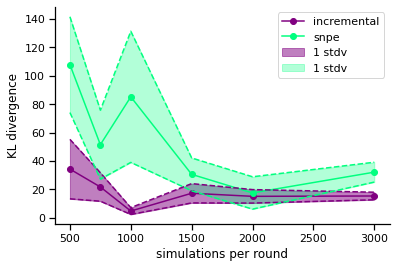

In [34]:
sns.set_context('notebook')
#sns.set_context('talk')

plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='purple')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='springgreen')

plt.plot(num_simulations_list, upper_incremental, '--', color='purple')
plt.plot(num_simulations_list, upper_snpe, '--',  color='springgreen')

plt.plot(num_simulations_list, lower_incremental, '--',  color='purple')
plt.plot(num_simulations_list, lower_snpe, '--',  color='springgreen')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='purple', alpha=0.5,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='springgreen', alpha=0.3, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()

